In [2]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import h5py
import lmdb
import caffe
from eval.inference import infer_to_h5_fixed_dims
from iow import read_lmdb, to_lmdb
from iow.lmdb_utils import MAP_SZ, IDX_FMT
from blobs.mat_utils import expand_dims

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [3]:
def path_to(path):
    return base_path + path
base_path = '/mnt/scratch/pierre/caffe_sandbox_tryouts/'
fpath_net = path_to('learning_curve/prototxt/net1_test.prototxt')
fpath_weights = path_to('learning_curve/snapshots/net1_snapshot_iter_10000.caffemodel')
fpath_db = path_to('inference/mnist_%s_train_lmdb')
fpath_h5 = path_to('inference/db.h5')

net = caffe.Net(fpath_net, fpath_weights, caffe.TEST) # or caffe.TRAIN
keys = ['data','label', 'score', 'accuracy', 'loss']
n = 100

infer_to_h5_fixed_dims(net, keys, n, fpath_h5, preserve_batch=True)

[100, 100, 100, 100, 100]

In [4]:
f = h5py.File(fpath_h5, 'r')

# True labels
y_true = f['label'].value[0]

# Predicted labels
y_pred = [np.argmax(y) for y in f['score'].value[0]]

# Score (~ softmax layer, here to be calculated)
def softmax(x):
    # Softmax on vector x
    e_x = np.exp(x)
    return e_x / e_x.sum()
def vectorize(scalar, classes):
    # Scalar is transformed in a vector with a 1 at position and zeros otherwise
    x = np.zeros(len(classes))
    x[scalar] = 1
    return x
y_score = f['score'].value[0]

In [5]:
# NOTES - IGNORE THIS PARAGRAPH

# Method to handle hdf5 db
def hdf5_reader(file_name, key):
    f = h5py.File(file_name, 'r')
    group = f[key]
    if isinstance(group, h5py.Dataset):
        yield group.value
    else:
        for key, value in dict(group).iteritems():
            datum = caffe.proto.caffe_pb2.Datum()
            datum.ParseFromString(value)
            label = int(datum.label)
            image = caffe.io.datum_to_array(datum).astype(np.uint8)
            yield key, flat_shape(image), label
# Output a prediction with caffe
y_score_ = np.zeros(y_true.shape, dtype=y_true.dtype)
for i, x in enumerate(f['data'].value[0]):
    net.blobs['data'].data[...] = x
    out = net.forward()
    y_score_[i] = out['loss']

/mnt/antares_raid/home/pierre/.virtualenvs/pierrenv/lib/python2.7/site-packages/ipykernel/__main__.py:17: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/mnt/antares_raid/home/pierre/.virtualenvs/pierrenv/local/lib/python2.7/site-packages/scikit_learn-0.17.1-py2.7-linux-x86_64.egg/sklearn/metrics/ranking.py:538: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


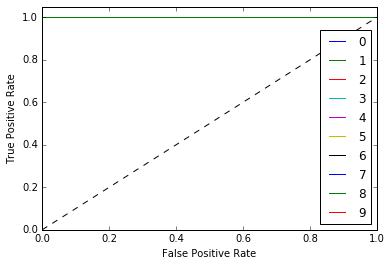

Accuracy: 0.99
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00         8
        1.0       1.00      1.00      1.00        14
        2.0       1.00      1.00      1.00         8
        3.0       1.00      1.00      1.00        11
        4.0       1.00      1.00      1.00        14
        5.0       0.88      1.00      0.93         7
        6.0       1.00      1.00      1.00        10
        7.0       1.00      1.00      1.00        15
        8.0       1.00      1.00      1.00         2
        9.0       1.00      0.91      0.95        11

avg / total       0.99      0.99      0.99       100

Confusion matrix:
[[ 8  0  0  0  0  0  0  0  0  0]
 [ 0 14  0  0  0  0  0  0  0  0]
 [ 0  0  8  0  0  0  0  0  0  0]
 [ 0  0  0 11  0  0  0  0  0  0]
 [ 0  0  0  0 14  0  0  0  0  0]
 [ 0  0  0  0  0  7  0  0  0  0]
 [ 0  0  0  0  0  0 10  0  0  0]
 [ 0  0  0  0  0  0  0 15  0  0]
 [ 0  0  0  0  0  0  0  0  2  0]
 [ 0  0  0  0  0  1  0  0  0 10

In [6]:
from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report, confusion_matrix
classes = range(10) # multi-class classifier

# ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for class_ in classes:
    fpr[class_], tpr[class_], _ = roc_curve(vectorize(y_true[class_], classes), softmax(y_score[class_]), pos_label=class_)
    roc_auc[class_] = auc(fpr[class_], tpr[class_])
plt.figure()
for class_ in classes:
    plt.plot(fpr[class_], tpr[class_], label=class_)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('')
plt.legend(loc="lower right")
plt.show()

# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print "Accuracy:", accuracy

# Precision/recall
report = classification_report(y_true, y_pred)
print report

# Confusion matrix
confusion = confusion_matrix(y_true, y_pred, labels=classes)
print "Confusion matrix:\n", confusion